# **Projeto de Disciplina**
## Big Data e Processamento Distribuído 
---
### **Aluno**: Kaio Vinícius Cândido de Souza
---
# **Dataset**
### **Dataset Utilizado**: ([Body performance Data](https://www.kaggle.com/kukuroo3/body-performance-data)) disponibilizado pelo Kaggle.

### **Descrição**: O foco deste dataset é avaliar a performance física de pessoas. A performance da pessoa é medida atráves de métricas de aptidão física e é classificada de A até D, sendo A a maior classificação.

### **Campos do Dataset**
1. **Age** : (Idade)
2. **Gender** : (Sexo)
3. **height_cm**  : (Altura em centímetros)
4. **weight_kg** : (Peso em quilos)
5. **body fat_%**: (Percentual de gordura corporal)
6. **diastolic** : (Pressão sanguínea diastólica por minuto)
7. **systolic** : (Pressão arterial sistólica)
8. **gripForce** : (Força de aperto)
9. **sit and bend forward_cm** : (Envergadura da posição sentada até a ponta dos pés)
10. **sit-ups counts** : (Quantidade de  abdominais feitos)
11. **broad jump_cm** : (Distância do salto em centímetros)
12. **class** : (Classificação - A,B,C,D)

---
### **Justificativa e Objetivo**
##### Este dataset foi escolhido com o intuito de criar um algorítmo de aprendizagem capaz de classificar a performance física do indivíduo com base nas informações fornecidas a ele. A classificação varia de A a D, sendo A a melhor classificação. O objetivo é realizar um ciclo de análise de ciência de dados completos utilizando o Spark.




In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

## 1. Setup do Projeto

In [2]:
import findspark
findspark.init('spark-3.2.0-bin-hadoop3.2')

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, Bucketizer
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
spark = SparkSession.builder.getOrCreate()

print(spark)

## 2. Análise e Exploração de dados

In [3]:
df = spark.read.csv('/content/bodyPerformance.csv', header=True, inferSchema=True, nullValue='NA')

body_performance_df = df.withColumnRenamed("body fat_%","body_fat").withColumnRenamed("sit and bend forward_cm","sit_bend_forward").withColumnRenamed("sit-ups counts","sit_ups_counts").withColumnRenamed("broad jump_cm","broad_jump_cm")
                        

In [4]:
body_performance_df.show(10)
body_performance_df.createOrReplaceTempView("body_performance")

+----+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+
| age|gender|height_cm|weight_kg|body_fat|diastolic|systolic|gripForce|sit_bend_forward|sit_ups_counts|broad_jump_cm|class|
+----+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+
|27.0|     M|    172.3|    75.24|    21.3|     80.0|   130.0|     54.9|            18.4|          60.0|        217.0|    C|
|25.0|     M|    165.0|     55.8|    15.7|     77.0|   126.0|     36.4|            16.3|          53.0|        229.0|    A|
|31.0|     M|    179.6|     78.0|    20.1|     92.0|   152.0|     44.8|            12.0|          49.0|        181.0|    C|
|32.0|     M|    174.5|     71.1|    18.4|     76.0|   147.0|     41.4|            15.2|          53.0|        219.0|    B|
|28.0|     M|    173.8|     67.7|    17.1|     70.0|   127.0|     43.5|            27.1|          45.0|        217.0|    B|
|36.0|  

####Esta é a base do nosso dataset, temos 4 classes que representam a "performance" de aptidão física de A a D sendo A a melhor classificação. O intuito é modelar os dados para que possamos treinar um modelo que classifique a performance de um ser humano baseado em sua aptidão física.

#### Será utilizado a função createOrReplaceTempView para criar uma visão temporária do dataframe como se fosse uma tabela de banco de dados, assim será possível utilizar o SQL e explorar os dados de uma maneira mais livre.

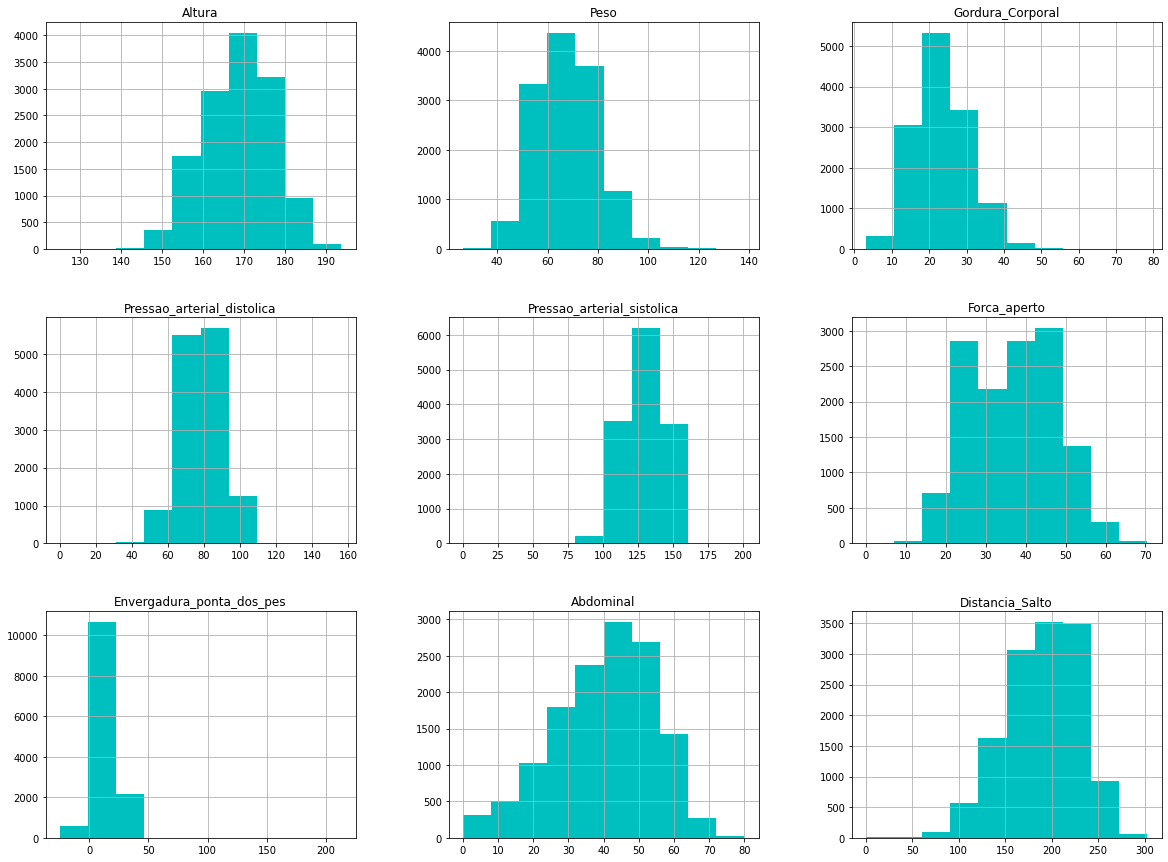

In [5]:
histograma = spark.sql(
                       "SELECT height_cm as Altura, weight_kg as Peso, body_fat as Gordura_Corporal, diastolic as Pressao_arterial_distolica, systolic as Pressao_arterial_sistolica, gripForce as Forca_aperto, sit_bend_forward as Envergadura_ponta_dos_pes, sit_ups_counts as Abdominal, broad_jump_cm as Distancia_Salto FROM body_performance"
                       ).toPandas()
histograma[histograma.columns].hist(color="c",figsize=(20,15))
plt.show()

#### De acordo com o histograma acima podemos observar que:

1.   A altura das pessoas análisadas varia de 1,25 a 1,95 metros de altura
2.   A variação do peso das pessoas vão de 25 a 130 quilos.
3.   O percentual de gordura das pessoas avaliadas varia entre 5% a 60%.
4.   A pressão arterial distólica está dentro da faixa de 0 mmHg a 110 mmHg.
5.   Pressão arterial sistólica está dentro da faixa de 0 mmHg a 160 mmHg.
6.   A força de aperto está na faixa de 0 a 70
7.   Os resultados dos testes de envergadura da posição sentada até a ponta dos pés estão na faixa de -25 cm a 49 cm.
8.   Contagem de abdominais variam de 0 a 80.
9.   Distância de saltos variam de 0 a 300 cm





In [6]:
gender_qtd = spark.sql(
    "SELECT CASE WHEN gender = 'F' THEN 'Feminino' ELSE 'Masculino' END as gender, count(*) as qtd FROM body_performance GROUP BY gender"
    ).toPandas()
gender_qtd

,gender,qtd
0,Feminino,4926
1,Masculino,8467


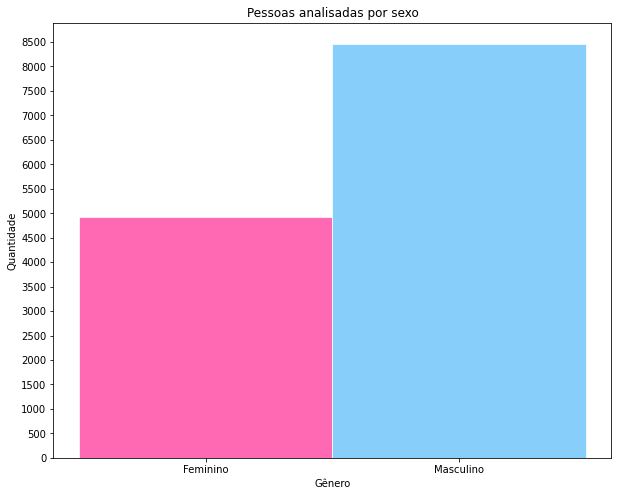

In [7]:
x = gender_qtd['gender']
y = gender_qtd['qtd']

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x, y, width=1, edgecolor="white", color=['hotpink','lightskyblue'], linewidth=0.7)

ax.set_title('Pessoas analisadas por sexo')
ax.set_xlabel('Gênero')
ax.yaxis.set_ticks(np.arange(0, 9000, 500))
ax.set_ylabel('Quantidade')

plt.show()

####Conforme podemos ver o gráfico acima, é possível observar que neste conjunto de dados pessoas do sexo masculino foram as mais analisadas.

In [8]:
distr_classe = spark.sql("SELECT class, count(*) as qtd FROM body_performance GROUP BY class").toPandas()
distr_classe

,class,qtd
0,B,3347
1,D,3349
2,C,3349
3,A,3348


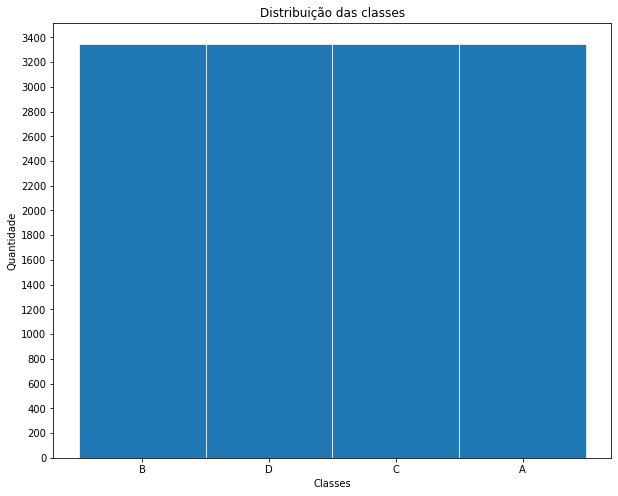

In [9]:
x = distr_classe['class']
y = distr_classe['qtd']

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set_title('Distribuição das classes')
ax.set_xlabel('Classes')
ax.yaxis.set_ticks(np.arange(0, 3600, 200))
ax.set_ylabel('Quantidade')

plt.show()

#### O grafico de distribuição de classe nos diz que a distribuição está bem equivalente entre A, B, C e D.

In [10]:
age_qtd = spark.sql("SELECT age, count(*) as qtd FROM body_performance GROUP BY age ORDER BY age ASC").toPandas()

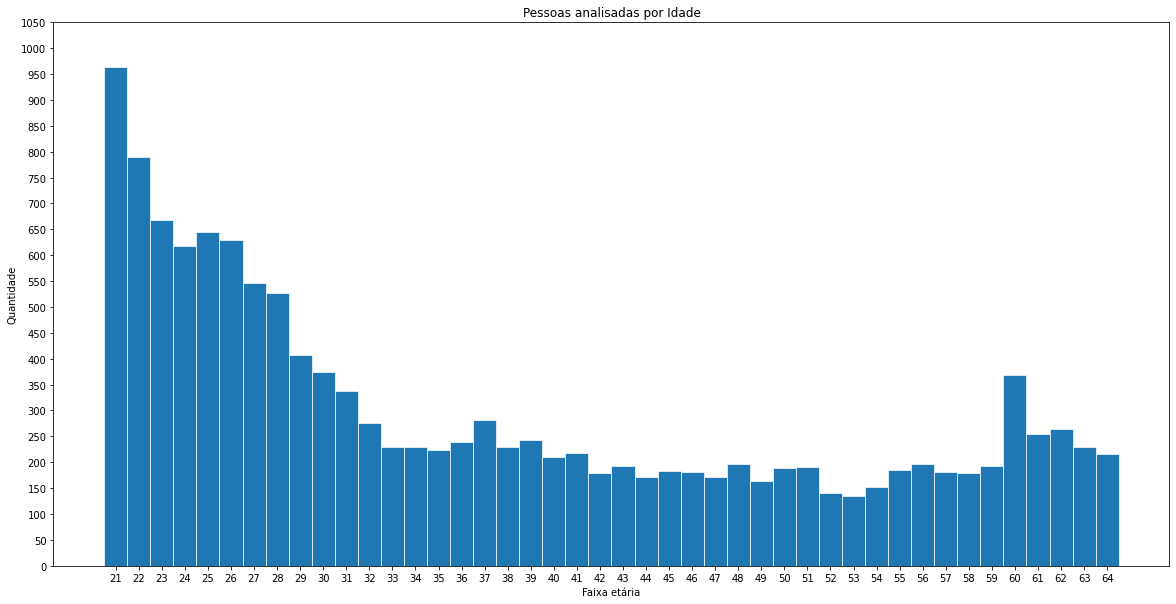

In [11]:
x = age_qtd['age']
y = age_qtd['qtd']

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set_title('Pessoas analisadas por Idade')
ax.xaxis.set_ticks(np.arange(21, 65, 1))
ax.set_xlabel('Faixa etária')
ax.yaxis.set_ticks(np.arange(0, 1100, 50))
ax.set_ylabel('Quantidade')

plt.show()

####Podemos ver também que a faixa etária entre 21 a 32 anos foi a faixa etária com maior número de análises. Em seguida veremos a faixa etária por gênero.



In [12]:
gender_age_qtd = spark.sql(
    "SELECT CASE WHEN gender = 'F' THEN 'Feminino' ELSE 'Masculino' END as gender, age, count(*) as qtd FROM body_performance GROUP BY gender, age ORDER BY age ASC"
    ).toPandas()
gender_age_qtd

,gender,age,qtd
0,Masculino,21.0,558
1,Feminino,21.0,406
2,Feminino,22.0,327
3,Masculino,22.0,462
4,Feminino,23.0,282
...,...,...,...
83,Feminino,62.0,118
84,Masculino,63.0,147
85,Feminino,63.0,83
86,Feminino,64.0,100


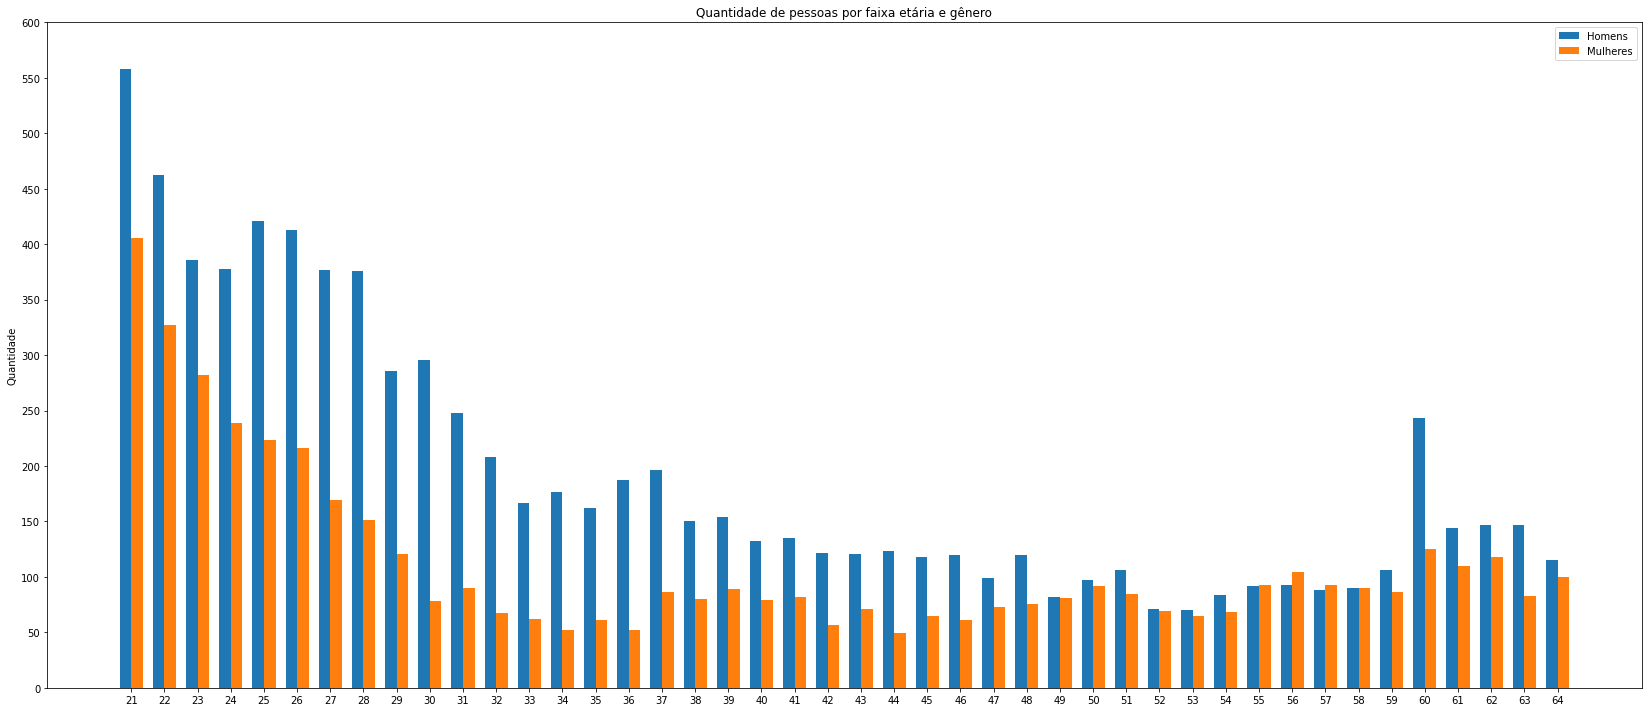

In [13]:
labels = age_qtd['age']
qtd_homens = gender_age_qtd[(gender_age_qtd['gender'] == 'Masculino')]
qtd_mulheres = gender_age_qtd[(gender_age_qtd['gender'] == 'Feminino')]

width = 0.35

fig, ax = plt.subplots(figsize=(23,10))
rects1 = ax.bar(qtd_mulheres['age'] - width/2, qtd_homens['qtd'], width, label='Homens')
rects2 = ax.bar(qtd_mulheres['age'] + width/2, qtd_mulheres['qtd'], width, label='Mulheres')

ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de pessoas por faixa etária e gênero')
ax.xaxis.set_ticks(np.arange(21, 65, 1))
ax.yaxis.set_ticks(np.arange(0, 650, 50))
ax.legend()

fig.tight_layout()

plt.show()

####Neste gráfico acima podemos ver que o número de homens analisados é superior que as mulheres em qualquer faixa etária.

In [14]:
gender_class_qtd = spark.sql(
    "SELECT CASE WHEN gender = 'F' THEN 'Feminino' ELSE 'Masculino' END as gender, class, count(*) as qtd FROM body_performance GROUP BY gender, class ORDER BY class ASC"
    ).toPandas()
gender_class_qtd

,gender,class,qtd
0,Masculino,A,1864
1,Feminino,A,1484
2,Masculino,B,2162
3,Feminino,B,1185
4,Masculino,C,2237
5,Feminino,C,1112
6,Masculino,D,2204
7,Feminino,D,1145


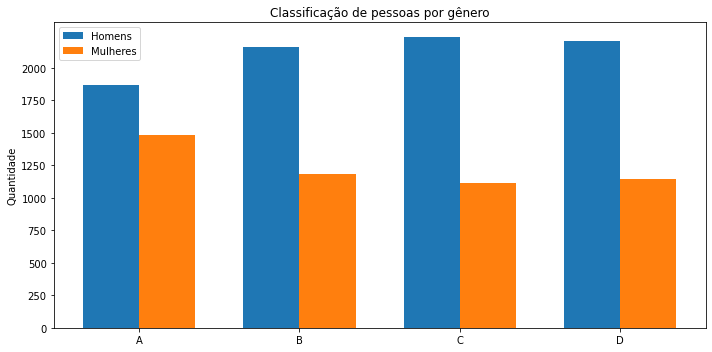

In [15]:
labels = gender_class_qtd['class']
qtd_homens = gender_class_qtd[(gender_class_qtd['gender'] == 'Masculino')]
qtd_mulheres = gender_class_qtd[(gender_class_qtd['gender'] == 'Feminino')]

n = 4
x = np.arange(4)
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width / 2, qtd_homens['qtd'], width, label='Homens')
rects2 = ax.bar(x + width / 2, qtd_mulheres['qtd'], width, label='Mulheres')

ax.set_ylabel('Quantidade')
ax.set_title('Classificação de pessoas por gênero')
ax.set_xticks(x)
ax.set_xticklabels(['A','B','C','D'])
ax.yaxis.set_ticks(np.arange(0, 2100, 250))
ax.legend()

fig.tight_layout()

plt.show()

#### No grafico de classificação por gênero conseguimos ver a distribuição da classificação de performance entre homens e mulheres. Como há mais homens do que mulheres neste conjunto de dados é natural que o número de homens seja maior em cada classificação.
#### Além disso, a maioria dos homens levaram a classificação C e a maiora das melhoras levaram a classificação A (a melhor), isto indica que mesmo as mulheres estando em menor número a performance física está melhor em relação aos homens.

## 3. Tratamento dos dados para treinamento

Mudando o tipo de variáveis para o tipo inteiro (integer). Foi identificado que as colunas (*'age', diastolic, 'systolic', 'sit_ups_counts' e 'broad_jump_cm'*) não possuem valores decimais por isso a decisão de torna-los inteiros.

In [16]:
print('Mudando o tipo de variaveis para o tipo inteiro')
body_performance_df = body_performance_df.withColumn('age',col('age').cast("integer"))
body_performance_df = body_performance_df.withColumn('diastolic',col('diastolic').cast("integer"))
body_performance_df = body_performance_df.withColumn('systolic',col('systolic').cast("integer"))
body_performance_df = body_performance_df.withColumn('sit_ups_counts',col('sit_ups_counts').cast("integer"))
body_performance_df = body_performance_df.withColumn('broad_jump_cm',col('broad_jump_cm').cast("integer"))
body_performance_df.printSchema()

Mudando o tipo de variaveis para o tipo inteiro
root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kg: double (nullable = true)
 |-- body_fat: double (nullable = true)
 |-- diastolic: integer (nullable = true)
 |-- systolic: integer (nullable = true)
 |-- gripForce: double (nullable = true)
 |-- sit_bend_forward: double (nullable = true)
 |-- sit_ups_counts: integer (nullable = true)
 |-- broad_jump_cm: integer (nullable = true)
 |-- class: string (nullable = true)



In [17]:
body_performance_df.show(10)

+---+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+
|age|gender|height_cm|weight_kg|body_fat|diastolic|systolic|gripForce|sit_bend_forward|sit_ups_counts|broad_jump_cm|class|
+---+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+
| 27|     M|    172.3|    75.24|    21.3|       80|     130|     54.9|            18.4|            60|          217|    C|
| 25|     M|    165.0|     55.8|    15.7|       77|     126|     36.4|            16.3|            53|          229|    A|
| 31|     M|    179.6|     78.0|    20.1|       92|     152|     44.8|            12.0|            49|          181|    C|
| 32|     M|    174.5|     71.1|    18.4|       76|     147|     41.4|            15.2|            53|          219|    B|
| 28|     M|    173.8|     67.7|    17.1|       70|     127|     43.5|            27.1|            45|          217|    B|
| 36|     F|    

#### 3.1 Indexando o gênero e a classe.

In [18]:
print('Indexando "gender"')
indexer = StringIndexer(inputCol='gender', outputCol='gender_idx')
indexer_model = indexer.fit(body_performance_df)
body_df_indexed = indexer_model.transform(body_performance_df)
body_df_indexed.select('gender', 'gender_idx').distinct().show()

print('Indexando "class"')
indexer = StringIndexer(inputCol='class', outputCol='class_idx')
indexer_model = indexer.fit(body_df_indexed)
body_df_indexed = indexer_model.transform(body_df_indexed)
body_df_indexed.select('class', 'class_idx').distinct().show()

Indexando "gender"
+------+----------+
|gender|gender_idx|
+------+----------+
|     F|       1.0|
|     M|       0.0|
+------+----------+

Indexando "class"
+-----+---------+
|class|class_idx|
+-----+---------+
|    B|      3.0|
|    C|      0.0|
|    D|      1.0|
|    A|      2.0|
+-----+---------+



#### 3.2 Transformando campos de valores contínuos em discretos com o Bucktizer.


In [20]:
bucket = Bucketizer(splits=[125,145,165,185,194], inputCol='height_cm', outputCol='height_cm_bucket')
body_df_bucket = bucket.transform(body_df_indexed)
body_df_bucket.select('height_cm','height_cm_bucket').distinct().show()

bucket = Bucketizer(splits=[0,120,129,139,180,205], inputCol='systolic', outputCol='systolic_bucket')
body_df_bucket = bucket.transform(body_df_bucket)
body_df_bucket.select('systolic','systolic_bucket').distinct().show()

bucket = Bucketizer(splits=[0,80,89,120,156], inputCol='diastolic', outputCol='diastolic_bucket')
body_df_bucket = bucket.transform(body_df_bucket)
body_df_bucket.select('diastolic','diastolic_bucket').distinct().show()

+---------+----------------+
|height_cm|height_cm_bucket|
+---------+----------------+
|    183.8|             2.0|
|    160.5|             1.0|
|    189.1|             3.0|
|    184.1|             2.0|
|    143.7|             0.0|
|    187.7|             3.0|
|    177.6|             2.0|
|    163.7|             1.0|
|    166.9|             2.0|
|    175.4|             2.0|
|    178.2|             2.0|
|    156.3|             1.0|
|    149.5|             1.0|
|    184.8|             2.0|
|    173.8|             2.0|
|    170.0|             2.0|
|    177.8|             2.0|
|    173.5|             2.0|
|    162.1|             1.0|
|    177.1|             2.0|
+---------+----------------+
only showing top 20 rows

+--------+---------------+
|systolic|systolic_bucket|
+--------+---------------+
|     103|            0.0|
|     201|            4.0|
|     120|            1.0|
|     106|            0.0|
|      84|            0.0|
|      91|            0.0|
|     158|            3.0|
|      9

####3.3 Transformando os buckets em OneHot

In [21]:
print('Criando one-hots para "height_cm", "systolic" e "diastolic"')
onehot = OneHotEncoder(inputCol='height_cm_bucket', outputCol='height_cm_oh')
body_df_oh = onehot.fit(body_df_bucket).transform(body_df_bucket)
body_df_oh.select('height_cm_bucket', 'height_cm_oh').distinct().show()

onehot = OneHotEncoder(inputCol='systolic_bucket', outputCol='systolic_oh')
body_df_oh = onehot.fit(body_df_oh).transform(body_df_oh)
body_df_oh.select('systolic_bucket', 'systolic_oh').distinct().show()

onehot = OneHotEncoder(inputCol='diastolic_bucket', outputCol='diastolic_oh')
body_df_oh = onehot.fit(body_df_oh).transform(body_df_oh)
body_df_oh.select('diastolic_bucket', 'diastolic_oh').distinct().show()

Criando one-hots para "height_cm", "systolic" e "diastolic"
+----------------+-------------+
|height_cm_bucket| height_cm_oh|
+----------------+-------------+
|             3.0|    (3,[],[])|
|             2.0|(3,[2],[1.0])|
|             1.0|(3,[1],[1.0])|
|             0.0|(3,[0],[1.0])|
+----------------+-------------+

+---------------+-------------+
|systolic_bucket|  systolic_oh|
+---------------+-------------+
|            0.0|(4,[0],[1.0])|
|            2.0|(4,[2],[1.0])|
|            3.0|(4,[3],[1.0])|
|            4.0|    (4,[],[])|
|            1.0|(4,[1],[1.0])|
+---------------+-------------+

+----------------+-------------+
|diastolic_bucket| diastolic_oh|
+----------------+-------------+
|             3.0|    (3,[],[])|
|             2.0|(3,[2],[1.0])|
|             1.0|(3,[1],[1.0])|
|             0.0|(3,[0],[1.0])|
+----------------+-------------+



In [22]:
body_df_oh.show(10)

+---+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+----------+---------+----------------+---------------+----------------+-------------+-------------+-------------+
|age|gender|height_cm|weight_kg|body_fat|diastolic|systolic|gripForce|sit_bend_forward|sit_ups_counts|broad_jump_cm|class|gender_idx|class_idx|height_cm_bucket|systolic_bucket|diastolic_bucket| height_cm_oh|  systolic_oh| diastolic_oh|
+---+------+---------+---------+--------+---------+--------+---------+----------------+--------------+-------------+-----+----------+---------+----------------+---------------+----------------+-------------+-------------+-------------+
| 27|     M|    172.3|    75.24|    21.3|       80|     130|     54.9|            18.4|            60|          217|    C|       0.0|      0.0|             2.0|            2.0|             1.0|(3,[2],[1.0])|(4,[2],[1.0])|(3,[1],[1.0])|
| 25|     M|    165.0|     55.8|    15.7|       77|     

#### 3.4 Simplificando os dados de treinamento em 2 colunas (features e class) e criando o vetor.

In [38]:
cols_to_use = ['age','height_cm_oh','weight_kg','body_fat','diastolic_oh', 'diastolic_oh', 'gripForce', 'sit_bend_forward', 'sit_ups_counts', 'broad_jump_cm', 'gender_idx']
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
body_df_vec = vec.transform(body_df_oh)
body_df_vec.select('features', 'class_idx').show(truncate=False)

+----------------------------------------------------------------------------------+---------+
|features                                                                          |class_idx|
+----------------------------------------------------------------------------------+---------+
|(17,[0,3,4,5,7,10,12,13,14,15],[27.0,1.0,75.24,21.3,1.0,1.0,54.9,18.4,60.0,217.0])|0.0      |
|(17,[0,3,4,5,6,9,12,13,14,15],[25.0,1.0,55.8,15.7,1.0,1.0,36.4,16.3,53.0,229.0])  |2.0      |
|(17,[0,3,4,5,8,11,12,13,14,15],[31.0,1.0,78.0,20.1,1.0,1.0,44.8,12.0,49.0,181.0]) |0.0      |
|(17,[0,3,4,5,6,9,12,13,14,15],[32.0,1.0,71.1,18.4,1.0,1.0,41.4,15.2,53.0,219.0])  |3.0      |
|(17,[0,3,4,5,6,9,12,13,14,15],[28.0,1.0,67.7,17.1,1.0,1.0,43.5,27.1,45.0,217.0])  |3.0      |
|[36.0,0.0,0.0,1.0,55.4,22.0,1.0,0.0,0.0,1.0,0.0,0.0,23.8,21.0,27.0,153.0,1.0]     |3.0      |
|[42.0,0.0,1.0,0.0,63.7,32.2,1.0,0.0,0.0,1.0,0.0,0.0,22.7,0.8,18.0,146.0,1.0]      |1.0      |
|(17,[0,3,4,5,7,10,12,13,14,15],[33.0,1.0,77.2,36.

## 4. Treinando e testando os algorítmos

#### Neste projeto utilizaremos três algorítmos de classificação sendo eles:
#### Os algorítmos testados são:
* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosted Tree Classifier

#### Estes algorítmos são ideais para treinar um conjunto de dados de **multiplas classes** como é o caso deste *dataset*. O conjunto será dividido em 80% para treinamento e 20% para realização de testes.

### 4.1 DecisionTreeClassifier

In [42]:
body_train, body_test = body_df_vec.randomSplit([0.8,0.2], seed=123)
print('Decision tree Classifier')
dt_body_model = DecisionTreeClassifier(featuresCol='features', labelCol='class_idx')
preds_dt_body = dt_body_model.fit(body_train).transform(body_test)
preds_dt_body.select('class_idx', 'prediction', 'probability').show(10, truncate=False)

multi_eval = MulticlassClassificationEvaluator().setLabelCol('class_idx')

acc_dt_body = round(multi_eval.evaluate(preds_dt_body, {multi_eval.metricName: 'accuracy'}),2)
prec_dt_body = round(multi_eval.evaluate(preds_dt_body, {multi_eval.metricName: 'weightedPrecision'}),2)
recall_dt_body = round(multi_eval.evaluate(preds_dt_body, {multi_eval.metricName: 'weightedRecall'}),2)

print('Matriz de confusão')
preds_dt_body.groupBy('class_idx', 'prediction').count().show()

print(f'Accuracy: {acc_dt_body}')
print(f'Precision: {prec_dt_body}')
print(f'Recall: {recall_dt_body}')

Decision tree Classifier
+---------+----------+----------------------------------------------------------------------------------+
|class_idx|prediction|probability                                                                       |
+---------+----------+----------------------------------------------------------------------------------+
|1.0      |0.0       |[0.44426494345718903,0.1680129240710824,0.10662358642972536,0.28109854604200324]  |
|3.0      |2.0       |[0.13050075872534142,0.04286798179059181,0.6047040971168437,0.22192716236722307]  |
|1.0      |1.0       |[0.002325581395348837,0.9976744186046511,0.0,0.0]                                 |
|0.0      |0.0       |[0.44426494345718903,0.1680129240710824,0.10662358642972536,0.28109854604200324]  |
|0.0      |0.0       |[0.44426494345718903,0.1680129240710824,0.10662358642972536,0.28109854604200324]  |
|2.0      |2.0       |[0.13050075872534142,0.04286798179059181,0.6047040971168437,0.22192716236722307]  |
|0.0      |3.0       

### 4.2 RandomForestClassifier

In [43]:
rfc = RandomForestClassifier(featuresCol='features', labelCol='class_idx', numTrees=50)
preds_rfc_body = rfc.fit(body_train).transform(body_test)
preds_rfc_body.select('class_idx', 'prediction', 'probability').show(10, truncate=False)

multi_eval = MulticlassClassificationEvaluator().setLabelCol('class_idx')

acc_rfc_body = round(multi_eval.evaluate(preds_dt_body, {multi_eval.metricName: 'accuracy'}),2)
prec_rfc_body = round(multi_eval.evaluate(preds_rfc_body, {multi_eval.metricName: 'weightedPrecision'}),2)
recall_rfc_body = round(multi_eval.evaluate(preds_rfc_body, {multi_eval.metricName: 'weightedRecall'}),2)

print('Matriz de confusão')
preds_rfc_body.groupBy('class_idx', 'prediction').count().show()

print(f'Accuracy: {acc_rfc_body}')
print(f'Precision: {prec_rfc_body}')
print(f'Recall: {recall_rfc_body}')

+---------+----------+----------------------------------------------------------------------------------+
|class_idx|prediction|probability                                                                       |
+---------+----------+----------------------------------------------------------------------------------+
|1.0      |0.0       |[0.45131809991235217,0.31292145939498683,0.05986892734634955,0.17589151334631148] |
|3.0      |2.0       |[0.18916011402015187,0.12516293587655034,0.4173754203685728,0.26830152973472504]  |
|1.0      |1.0       |[0.06229598756801269,0.8949825751398601,0.012327993688156659,0.030393443603970526]|
|0.0      |0.0       |[0.3818293096011098,0.32998738814246986,0.07785404682653146,0.21032925542988873]  |
|0.0      |0.0       |[0.391738221314738,0.22165398594827754,0.11379913278973296,0.27280865994725145]   |
|2.0      |2.0       |[0.1889134175738914,0.12395081505067522,0.43297899062828343,0.25415677674715]     |
|0.0      |2.0       |[0.22613911289879304,0.0

## 4.3 Gradient Boosted Tree Classifier

In [44]:
gbt = GBTClassifier(featuresCol='features', labelCol='class_idx', maxIter=50)
preds_gbt_body = rfc.fit(body_train).transform(body_test)
preds_gbt_body.select('class_idx', 'prediction', 'probability').show(10, truncate=False)

multi_eval = MulticlassClassificationEvaluator().setLabelCol('class_idx')

acc_gbt_body = round(multi_eval.evaluate(preds_dt_body, {multi_eval.metricName: 'accuracy'}),2)
prec_gbt_body = round(multi_eval.evaluate(preds_gbt_body, {multi_eval.metricName: 'weightedPrecision'}),2)
recall_gbt_body = round(multi_eval.evaluate(preds_gbt_body, {multi_eval.metricName: 'weightedRecall'}),2)

print('Matriz de confusão')
preds_gbt_body.groupBy('class_idx', 'prediction').count().show()

print(f'Accuracy: {acc_gbt_body}')
print(f'Precision: {prec_gbt_body}')
print(f'Recall: {recall_gbt_body}')

+---------+----------+----------------------------------------------------------------------------------+
|class_idx|prediction|probability                                                                       |
+---------+----------+----------------------------------------------------------------------------------+
|1.0      |0.0       |[0.45131809991235217,0.31292145939498683,0.05986892734634955,0.17589151334631148] |
|3.0      |2.0       |[0.18916011402015187,0.12516293587655034,0.4173754203685728,0.26830152973472504]  |
|1.0      |1.0       |[0.06229598756801269,0.8949825751398601,0.012327993688156659,0.030393443603970526]|
|0.0      |0.0       |[0.3818293096011098,0.32998738814246986,0.07785404682653146,0.21032925542988873]  |
|0.0      |0.0       |[0.391738221314738,0.22165398594827754,0.11379913278973296,0.27280865994725145]   |
|2.0      |2.0       |[0.1889134175738914,0.12395081505067522,0.43297899062828343,0.25415677674715]     |
|0.0      |2.0       |[0.22613911289879304,0.0

#5.Discussão dos resultados
---
#### Vemos que o *Decision Tree Classifier* atingiu a acurácia de 59% e teve sua precisão (*precision*) de 60% o que significa que de todas pessoas classificadas este percentual realmente é positivo. E seu *recall* equivalente a 59% o que significa que de todas as análises que realmente são positivos, este é o percentual  que é identificado corretamente pelo modelo.

#### Já o *Random Forest Classifier* também atingiu uma acurácia de 59% porém sua precisão (*precision*) foi de 62% o que significa que de todas pessoas classificadas este percentual realmente é positivo. E seu *recall* de 61% o que significa que de todas as análises que realmente são positivas, este é o percentual que é identificado corretamente pelo modelo.

#### O *Gradient Boosted Tree Classifier* teve suas métricas exatamente iguais ao *Random Forest Classifier*.

#6. Conclusão


---
####Fizemos uma breve análise exploratória nos dados e observamos que neste conjunto de dados, pessoas entre a idade de 21 a 64 foram analisadas. Além disso, o número de pessoas analisadas do sexo masculino supera o feminino em qualquer faixa etária.
####Podemos concluir também que apesar do número da mulher ser inferior ao homem, sua classicação A foi a que atingiu maior número.

####Referente ao treinamento foram realizadas transformações no conjunto de dados utilizando o *StringIndexer*, *OneHotEncoder*, *Bucketizer* e o *VectorAssembler* para preparar os dados para os algorítmos de classificação.
####Apesar de que todos os algorítmos de classificação atingiram uma acurácia de 59%, para este projeto o melhor algorítmo foi o `RandomForestClassifier` e `GBTClassifier`, pelo detalhe de terem atingido a precisão maior que o `DecisionTreeClassifier`.
